In [1]:
# Imports
import numpy as np
import pandas as pd 
import networkx as nx
import community
import ast
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.ensemble import IsolationForest


import seaborn as sns
sns.set()
sns.set_style('white')
sequential_colors = sns.color_palette('Set3')
from mpl_toolkits.axes_grid1 import make_axes_locatable

# sns.palplot(sequential_colors)
# Need to set seaborn stuff twice
sns.set()
sns.set_style('white')
sequential_colors = sns.color_palette('Set3')

# Load the Data

In [2]:
df_allG = pd.read_csv('all_genres.csv')
df_allG.head()

,Unnamed: 0,GENRE,SIM_GENRES,SIM_WEIGHTS,OPP_GENRES,OPP_WEIGHTS,REL_ARTISTS,ARTIST_WEIGHTS,SPOTIFY_URL
0,0,backgroundmusic,"['reiki', 'calminginstrumental', 'yoga', 'back...","['103', '120', '101', '240', '102', '125', '11...","['mahraganat', 'divahouse', 'oldschoolukhiphop...","['160', '100', '121', '110', '135', '136', '12...","['NoemiNucci', 'JuditheAbelsen', 'FabienneWill...","['113', '117', '106', '131', '109', '115', '11...",https://open.spotify.com/user/thesoundsofspoti...
1,1,classicmoroccanpop,"['bluesrock', 'andalusianclassical', 'chaabima...","['103', '107', '109', '100', '102', '103', '10...","['shiverpop', 'gravewave', 'tassieindie', 'est...","['112', '112', '105', '102', '124', '100', '16...","['HajHusseinToulali', 'AbdelhadiBelkheyat', 'H...","['102', '103', '103', '108', '108', '102', '10...",https://open.spotify.com/user/thesoundsofspoti...
2,2,orthodoxchant,"['universitychoir', 'polishchoir', 'ukrainianc...","['102', '105', '107', '104', '106', '240', '10...","['sambass', 'funkybreaks', 'hardbass', 'hardco...","['107', '110', '158', '100', '119', '111', '10...","['LegeArtis', 'PeterMichaelides', 'CapellaGreg...","['114', '100', '160', '127', '115', '115', '10...",https://open.spotify.com/user/thesoundsofspoti...
3,3,tar,"['oud', 'persiantraditional', 'bansuri', 'tar'...","['106', '120', '101', '240', '103', '113', '10...","['happyhardcore', 'aggrotech', 'nightcore', 'b...","['109', '107', '127', '114', '115', '120', '12...","['KiyarashSaket', 'YusefForutan', 'HamidMoteba...","['100', '100', '111', '100', '100', '100', '10...",https://open.spotify.com/user/thesoundsofspoti...
4,4,reggae,"['dancehall', 'brazilianreggae', 'skarevival',...","['109', '105', '114', '101', '100', '127', '11...","['brazilianlo-firock', 'martialindustrial', 'p...","['106', '107', '155', '121', '160', '108', '14...","['TheItals', 'MykalRose', 'JohnnieClark', 'Asw...","['101', '102', '100', '105', '101', '105', '10...",https://open.spotify.com/user/thesoundsofspoti...


In [3]:
play_features = pd.read_csv('play_id_to_features.csv')
play_features['genre'] = df_allG['GENRE']


for column in play_features.columns[1:13]:
    e = play_features[column] - play_features[column].mean()
    play_features[column] = e / play_features[column].std()
display(play_features.head())
len(play_features)

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,2JsqQdMbBC2hh7GjsEjKFg,-2.159357,-2.562152,-2.008883,-3.683835,0.197873,-0.479995,2.053862,2.485280,-1.280608,-2.032534,-2.925935,-1.836564,backgroundmusic
1,2SoQc6bippmMyUTn1qditv,-0.045841,0.175432,-2.359753,0.051032,0.617096,-0.018311,0.440291,-0.661926,1.596669,1.229494,-0.129834,-2.163121,classicmoroccanpop
2,1KZMCWImik3vA17zVLJ3c3,-2.222290,-2.114273,0.205981,-2.115441,-0.500833,-0.503627,2.211593,-0.119368,-0.688578,-1.765563,-1.853072,-1.248761,orthodoxchant
3,1i9zTcQqWUBTgIuCgxDW3S,-0.641507,-1.245090,-0.539617,-0.761585,0.547225,-0.328623,1.961285,2.316611,-0.877141,-0.396911,-1.403512,-1.836564,tar
4,0TcXdt4sbITbwCwwFbKYyd,1.793356,-0.433154,-0.342252,-0.124784,-0.710445,0.543419,-0.693585,-0.492203,-0.759630,1.453458,-0.254475,0.775892,reggae


3652

# Generate $M^TM$ and $MM^T$

In [4]:
# Generate M matrix
M = []
for idx, row in play_features.iterrows():
    m_vec = [float(i) for i in row[1:13]]
    M.append(m_vec)
M = np.array(M)
print(M.shape)

(3652, 12)


In [5]:
MTM = M.T @ M
MMT = M @ M.T
print(MTM.shape, MMT.shape)

(12, 12) (3652, 3652)


In [6]:
# Choose MTM because it's smaller
evals_MTM, evecs_MTM = np.linalg.eig(MTM)
print(evals_MTM)

[16149.16404646  6454.45305054  5339.29179394  4733.69962522
  3263.45409323  2458.71112599   131.19473503   358.15334312
   609.11970919  1080.53370567  1665.4270611   1568.79771052]


# Plotting Function for $v_i$ vs $v_j$

In [7]:
def plot_evecproj(evecs, idx_1, idx_2, M):
    # Get Evecs Needed

    E_k2 = np.array([evecs_MTM[idx_1], evecs_MTM[idx_2]]).T
    ME_k2 = M @ E_k2
    v1_data, v2_data = zip(*ME_k2)
    
    # Outlier Stuff
    df = pd.DataFrame({'x': v1_data, 'y': v2_data})
    iso_forest = IsolationForest(contamination = .1, behaviour = 'new', n_estimators = 300, n_jobs = 4).fit(df)

    iso_f = iso_forest.decision_function(df)
    
    
    # Plotting
    plt.rcParams['figure.dpi'] = 500
    fig, ax = plt.subplots(1, figsize = (10,6))
    color = ax.scatter(df['x'], df['y'], 10, c = iso_f, cmap = 'viridis')
    ax.set_xlabel(r'$v_{}$'.format(idx_1))
    ax.set_ylabel(r'$v_{}$'.format(idx_2))
    ax.set_title('PCA ' + r'$v_{} \times v_{}$ with Isolation Forests'.format(idx_1, idx_2))
    ax.grid(False)
    plt.colorbar(color)
    fig.savefig('./images/' + 'evecs_{}_{}'.format(idx_1, idx_2) + '.png', bbox_inches = 'tight', facecolor = 'w', edgecolor = 'k')
    plt.show()

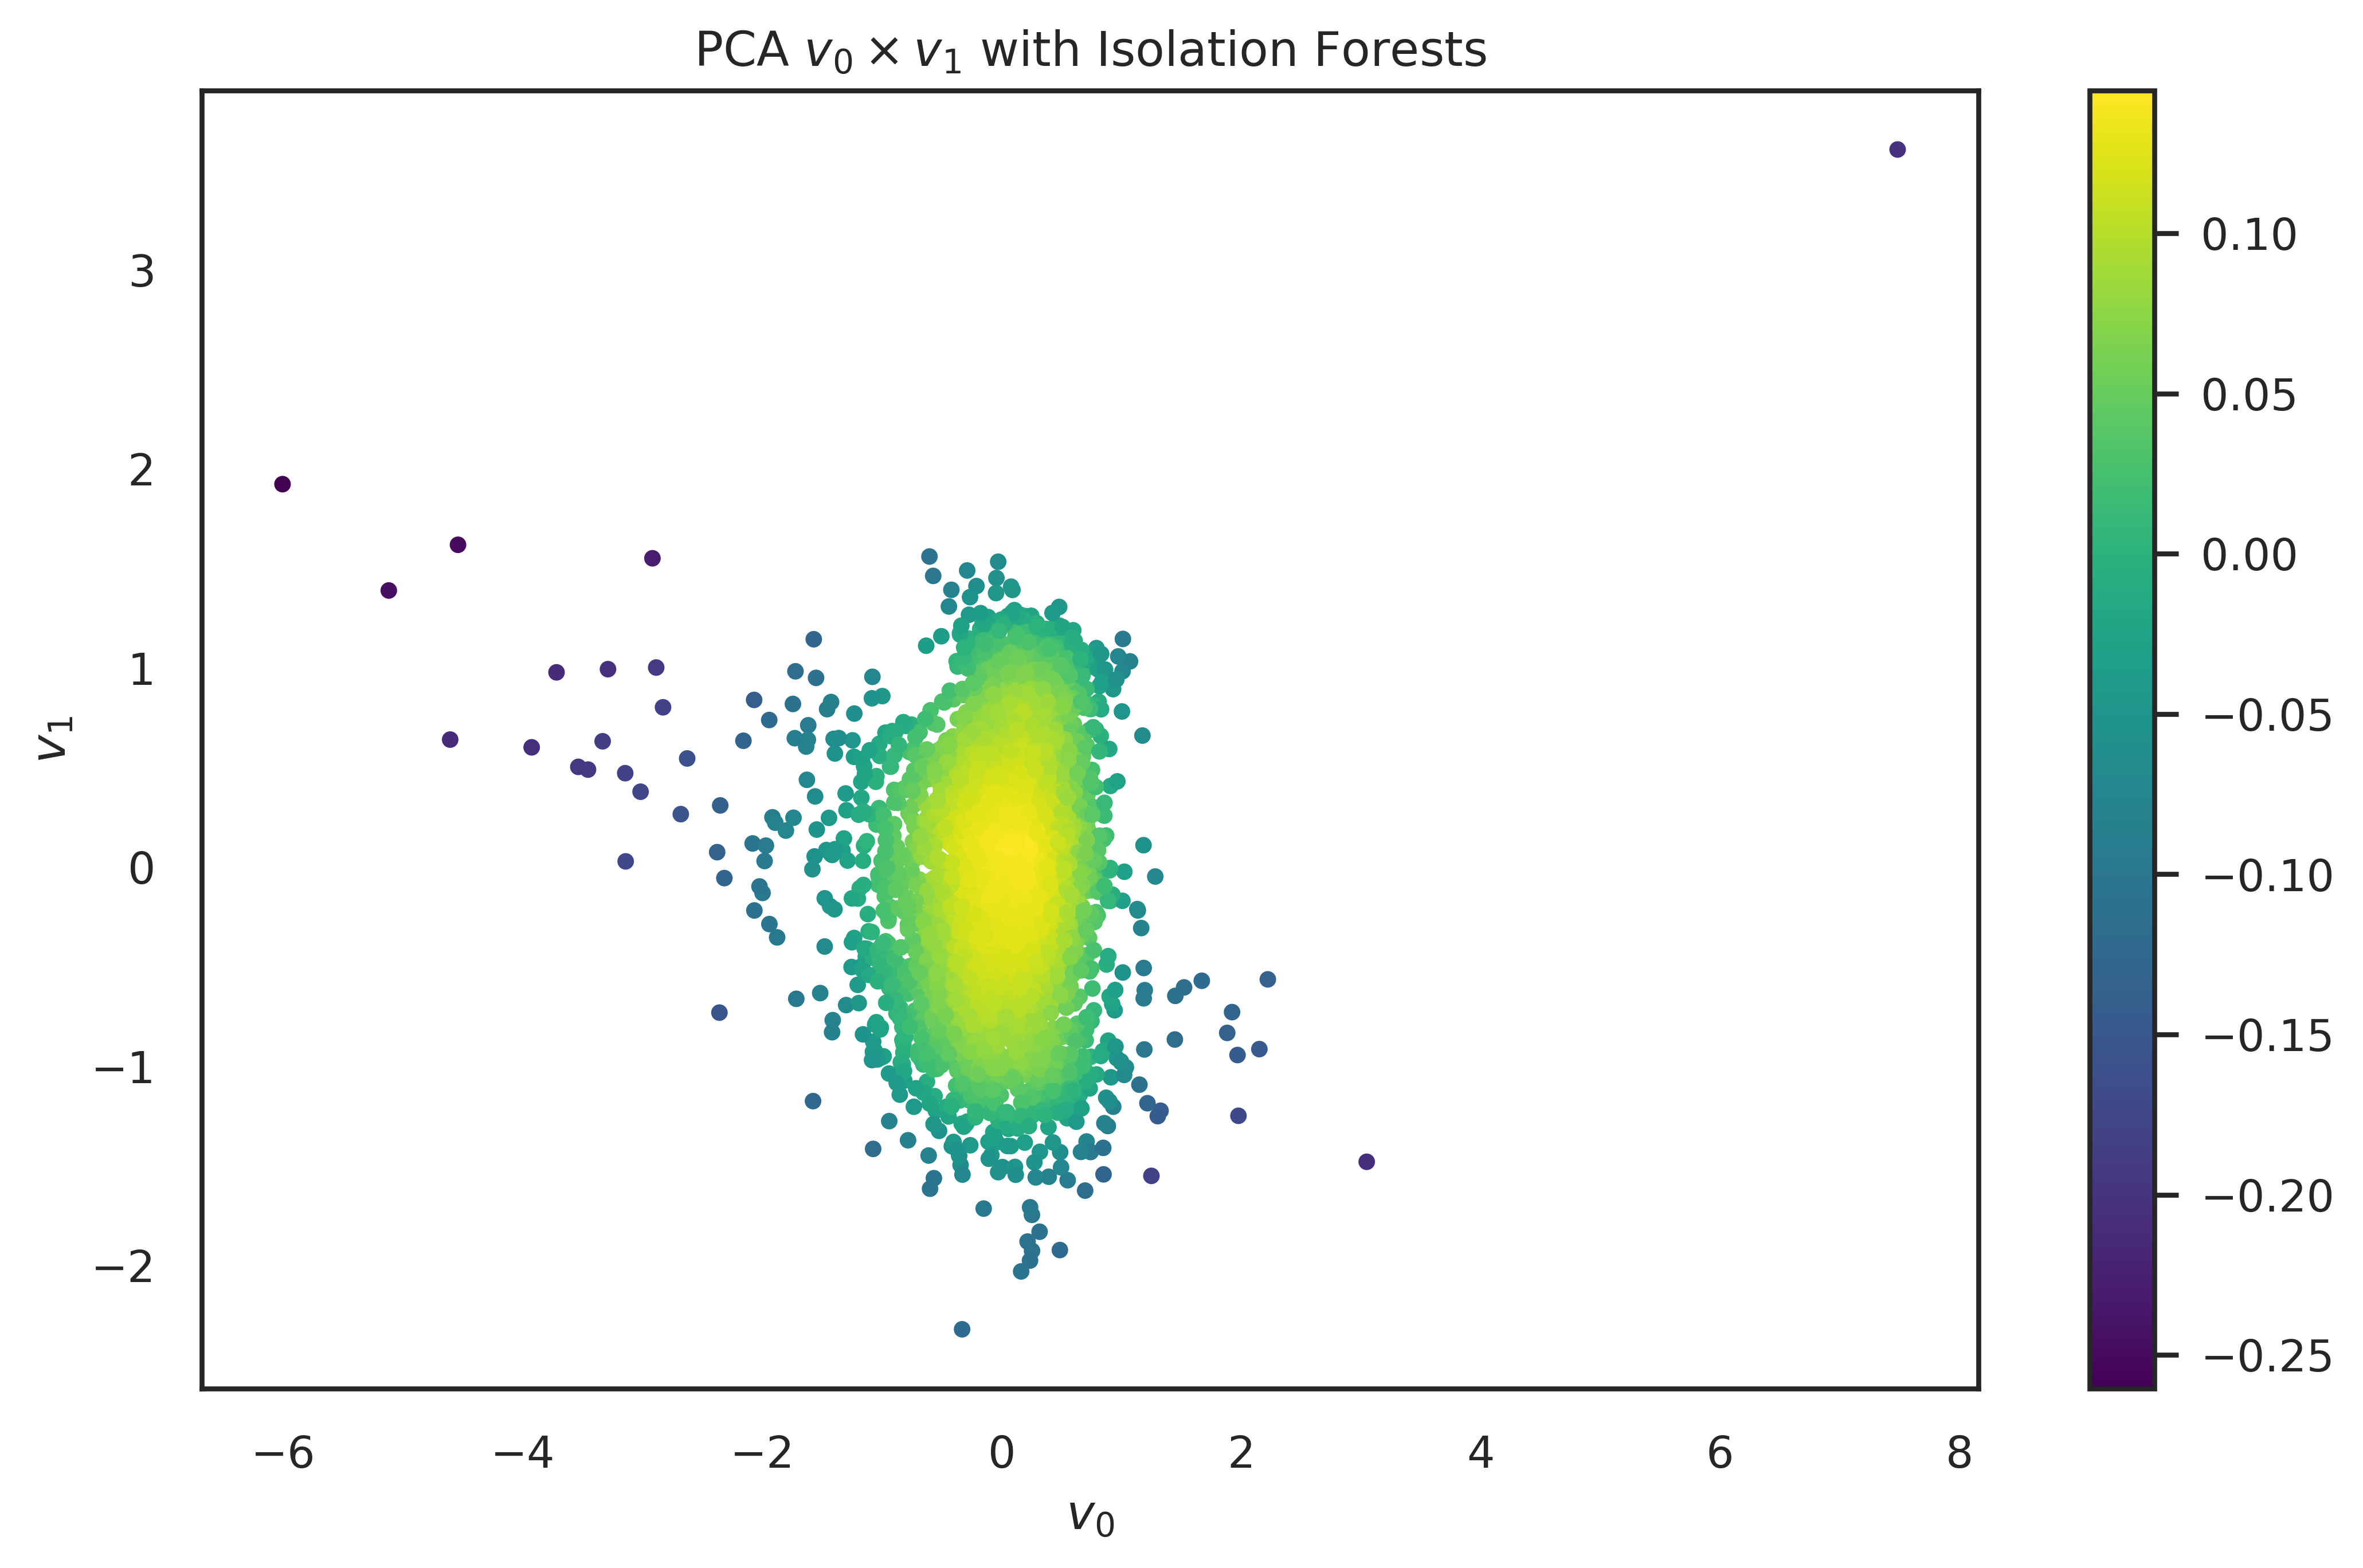

In [8]:
plot_evecproj(evecs_MTM, 0,1, M)

# Plotting $v_{i}$ vs $v_{i+1}$

In [9]:
def plot_evecproj_all(evecs, M):

    plt.rcParams['figure.dpi'] = 500
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize = (8.5, 11))
    e1 = 1
    e2 = 2
    for i in range(5):
        for j in range(2):
            
            # Get eigenvectors
            vi = evecs_MTM[e1]
            vj = evecs_MTM[e2]
            E_k2 = np.array([vi, vj]).T
            ME_k2 = M @ E_k2
            
            v1_data, v2_data = list(map(list,zip(*ME_k2)))
            
            # Outlier Stuff
            df = pd.DataFrame({'x': v1_data, 'y': v2_data})
            iso_forest = IsolationForest(contamination = .1, behaviour = 'new', n_estimators = 300, n_jobs = 4).fit(df)
            iso_f = iso_forest.decision_function(df)
            
            # Plotting
            color = axes[i,j].scatter(df['x'], df['y'], s = 10, c = iso_f, cmap = 'viridis', alpha = 0.9)
            xlabel = r'$v_{{{}}}$'.format(e1)
            ylabel = r'$v_{{{}}}$'.format(e2)
            axes[i,j].set_xlabel(xlabel, fontsize = 7)
            axes[i,j].set_ylabel(ylabel, fontsize = 7)
            axes[i,j].set_title(r'PCA ' + r'$v_{{{}}} \times v_{{{}}}$'.format(e1, e2), fontsize = 8)
            axes[i,j].tick_params(axis ='x', labelsize=8)
            axes[i,j].tick_params(axis ='y', labelsize=8)
            axes[i,j].set_yscale('linear')
            axes[i,j].set_xscale('linear')
            axes[i,j].grid(False)
            e1 += 1
            e2 += 1
    im = plt.gca().get_children()[0]
    fig.tight_layout()
    fig.subplots_adjust(right = 0.825, top = 0.93)
    cax = fig.add_axes([0.85, 0.06, 0.035, 0.88])
    fig.colorbar(im, cax = cax)
    fig.suptitle(r'Various $PCA$ Combinations with Isolation Forest Outliers', fontsize = 12)

    plt.show()

    fig.savefig('./images/' + 'evecs_1_11' + '.png', bbox_inches = 'tight', facecolor = 'w', edgecolor = 'k')
    plt.show()

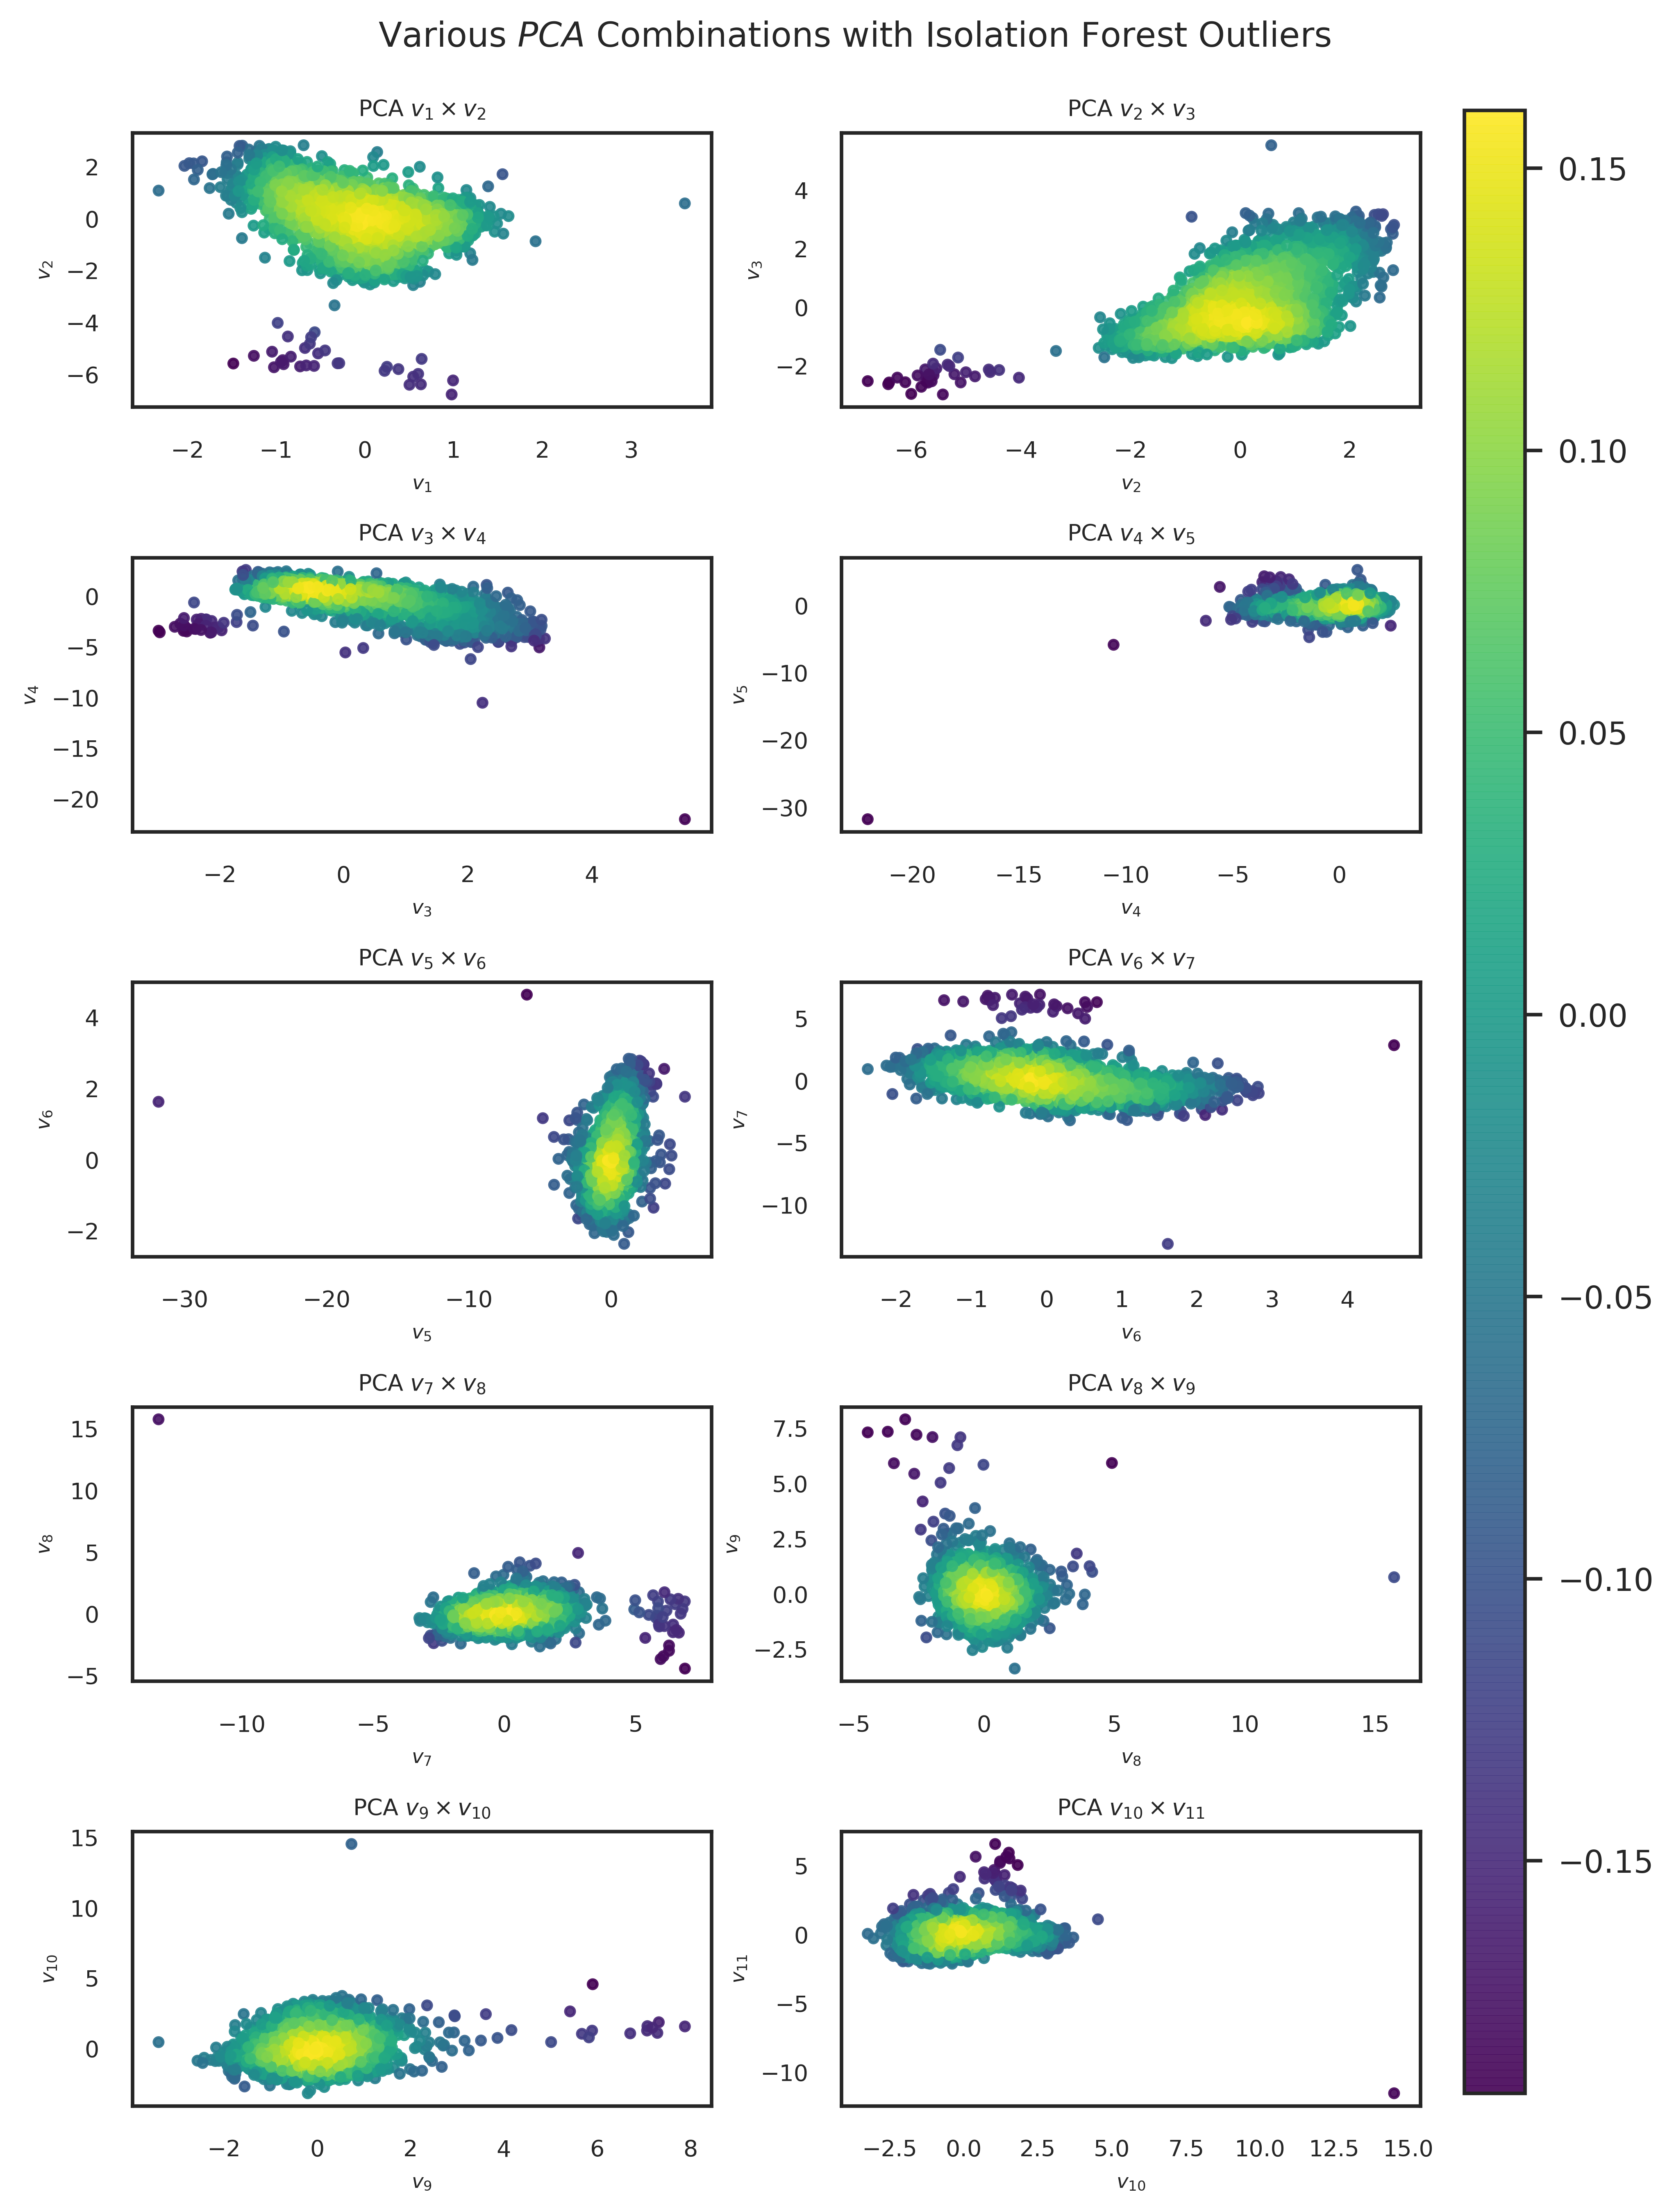

In [10]:
plot_evecproj_all(evecs_MTM, M)

# Plotting Eivenvector to Feature Correlation Matrix
A little bit easier to use the sklearn functions for this task.

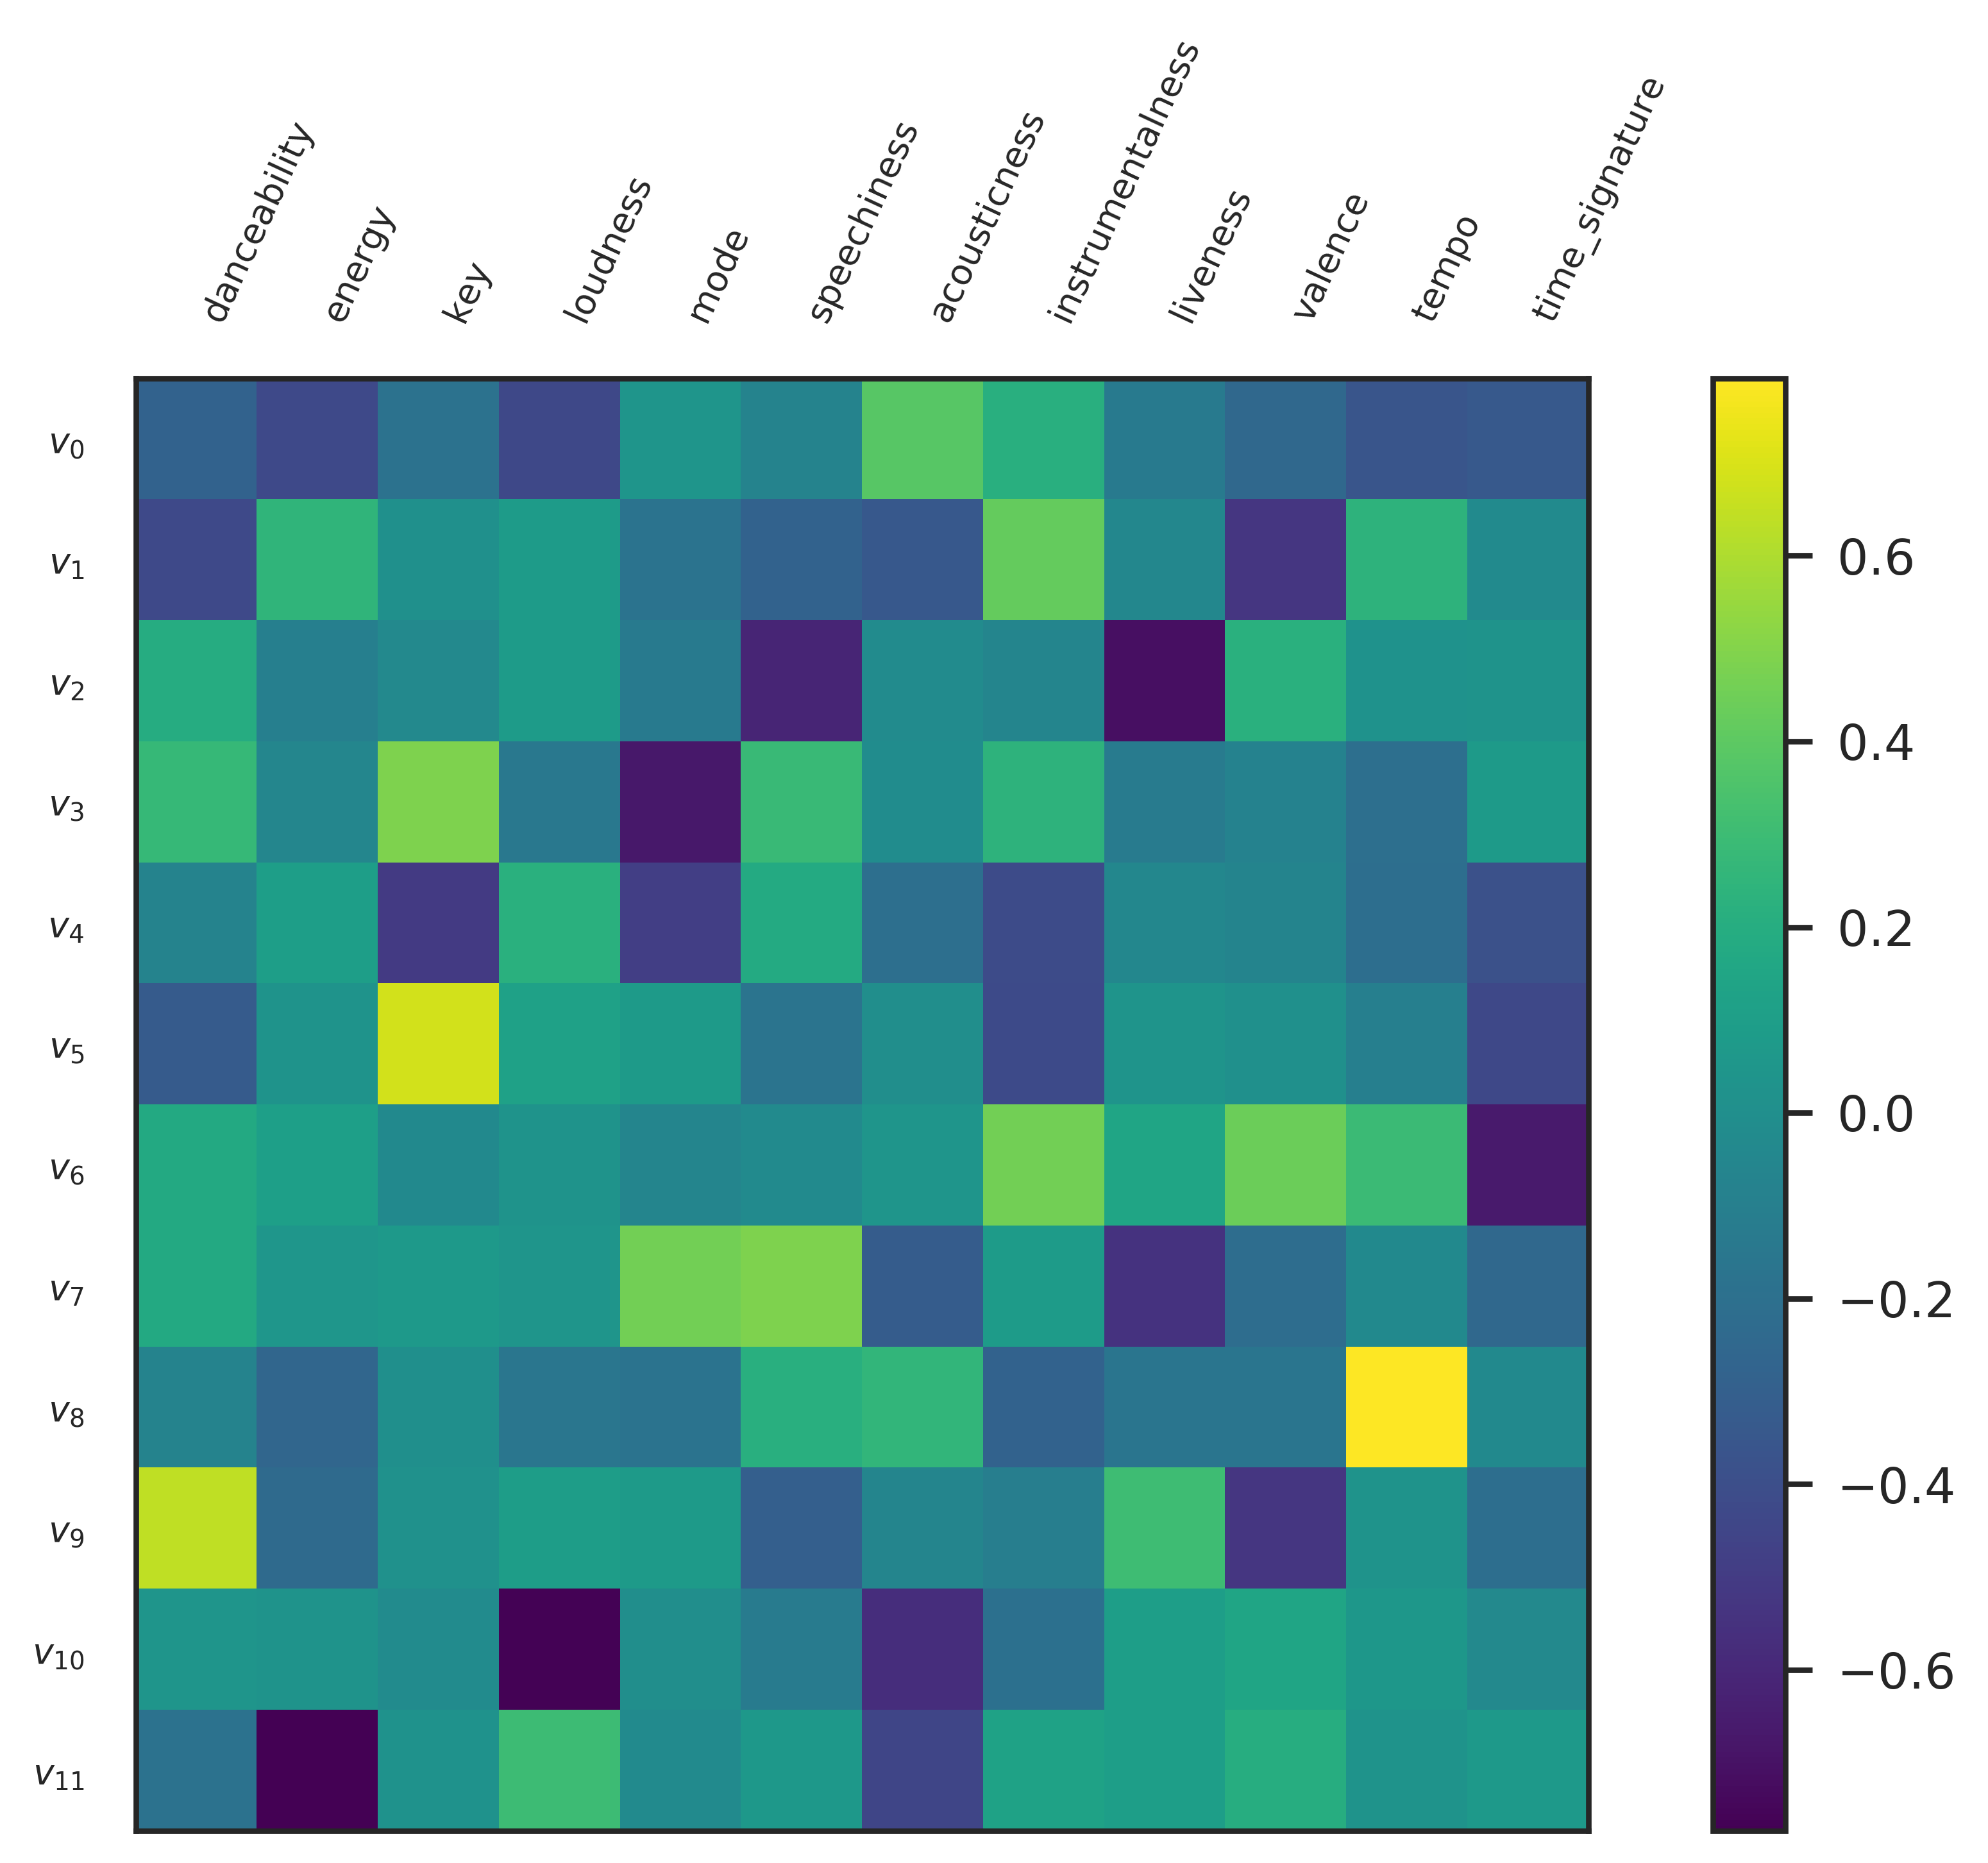

In [11]:
from sklearn.decomposition import PCA
pca_play_features = PCA()

pca_play_features.fit(play_features.iloc[:,1:13])
pca_features = pca_play_features.transform(play_features.iloc[:,1:13]) 


# Plotting
fig, ax = plt.subplots(1, figsize = (10,6))
im = ax.matshow(pca_play_features.components_, cmap = 'viridis')
plt.colorbar(im)
plt.yticks([i for i in range(12)],[r'$v_{{{}}}$'.format(v) for v in range(12)], fontsize = 8)
plt.xticks(range(12),list(play_features.columns)[1:13] ,rotation = 65, ha = 'left', fontsize = 8)
plt.tight_layout

plt.tick_params(axis = 'x', top = False, bottom = False, labelbottom = False)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig.savefig('./images/' + 'evecs_heatmap' + '.png', bbox_inches = 'tight', facecolor = 'w', edgecolor = 'k')


plt.show()

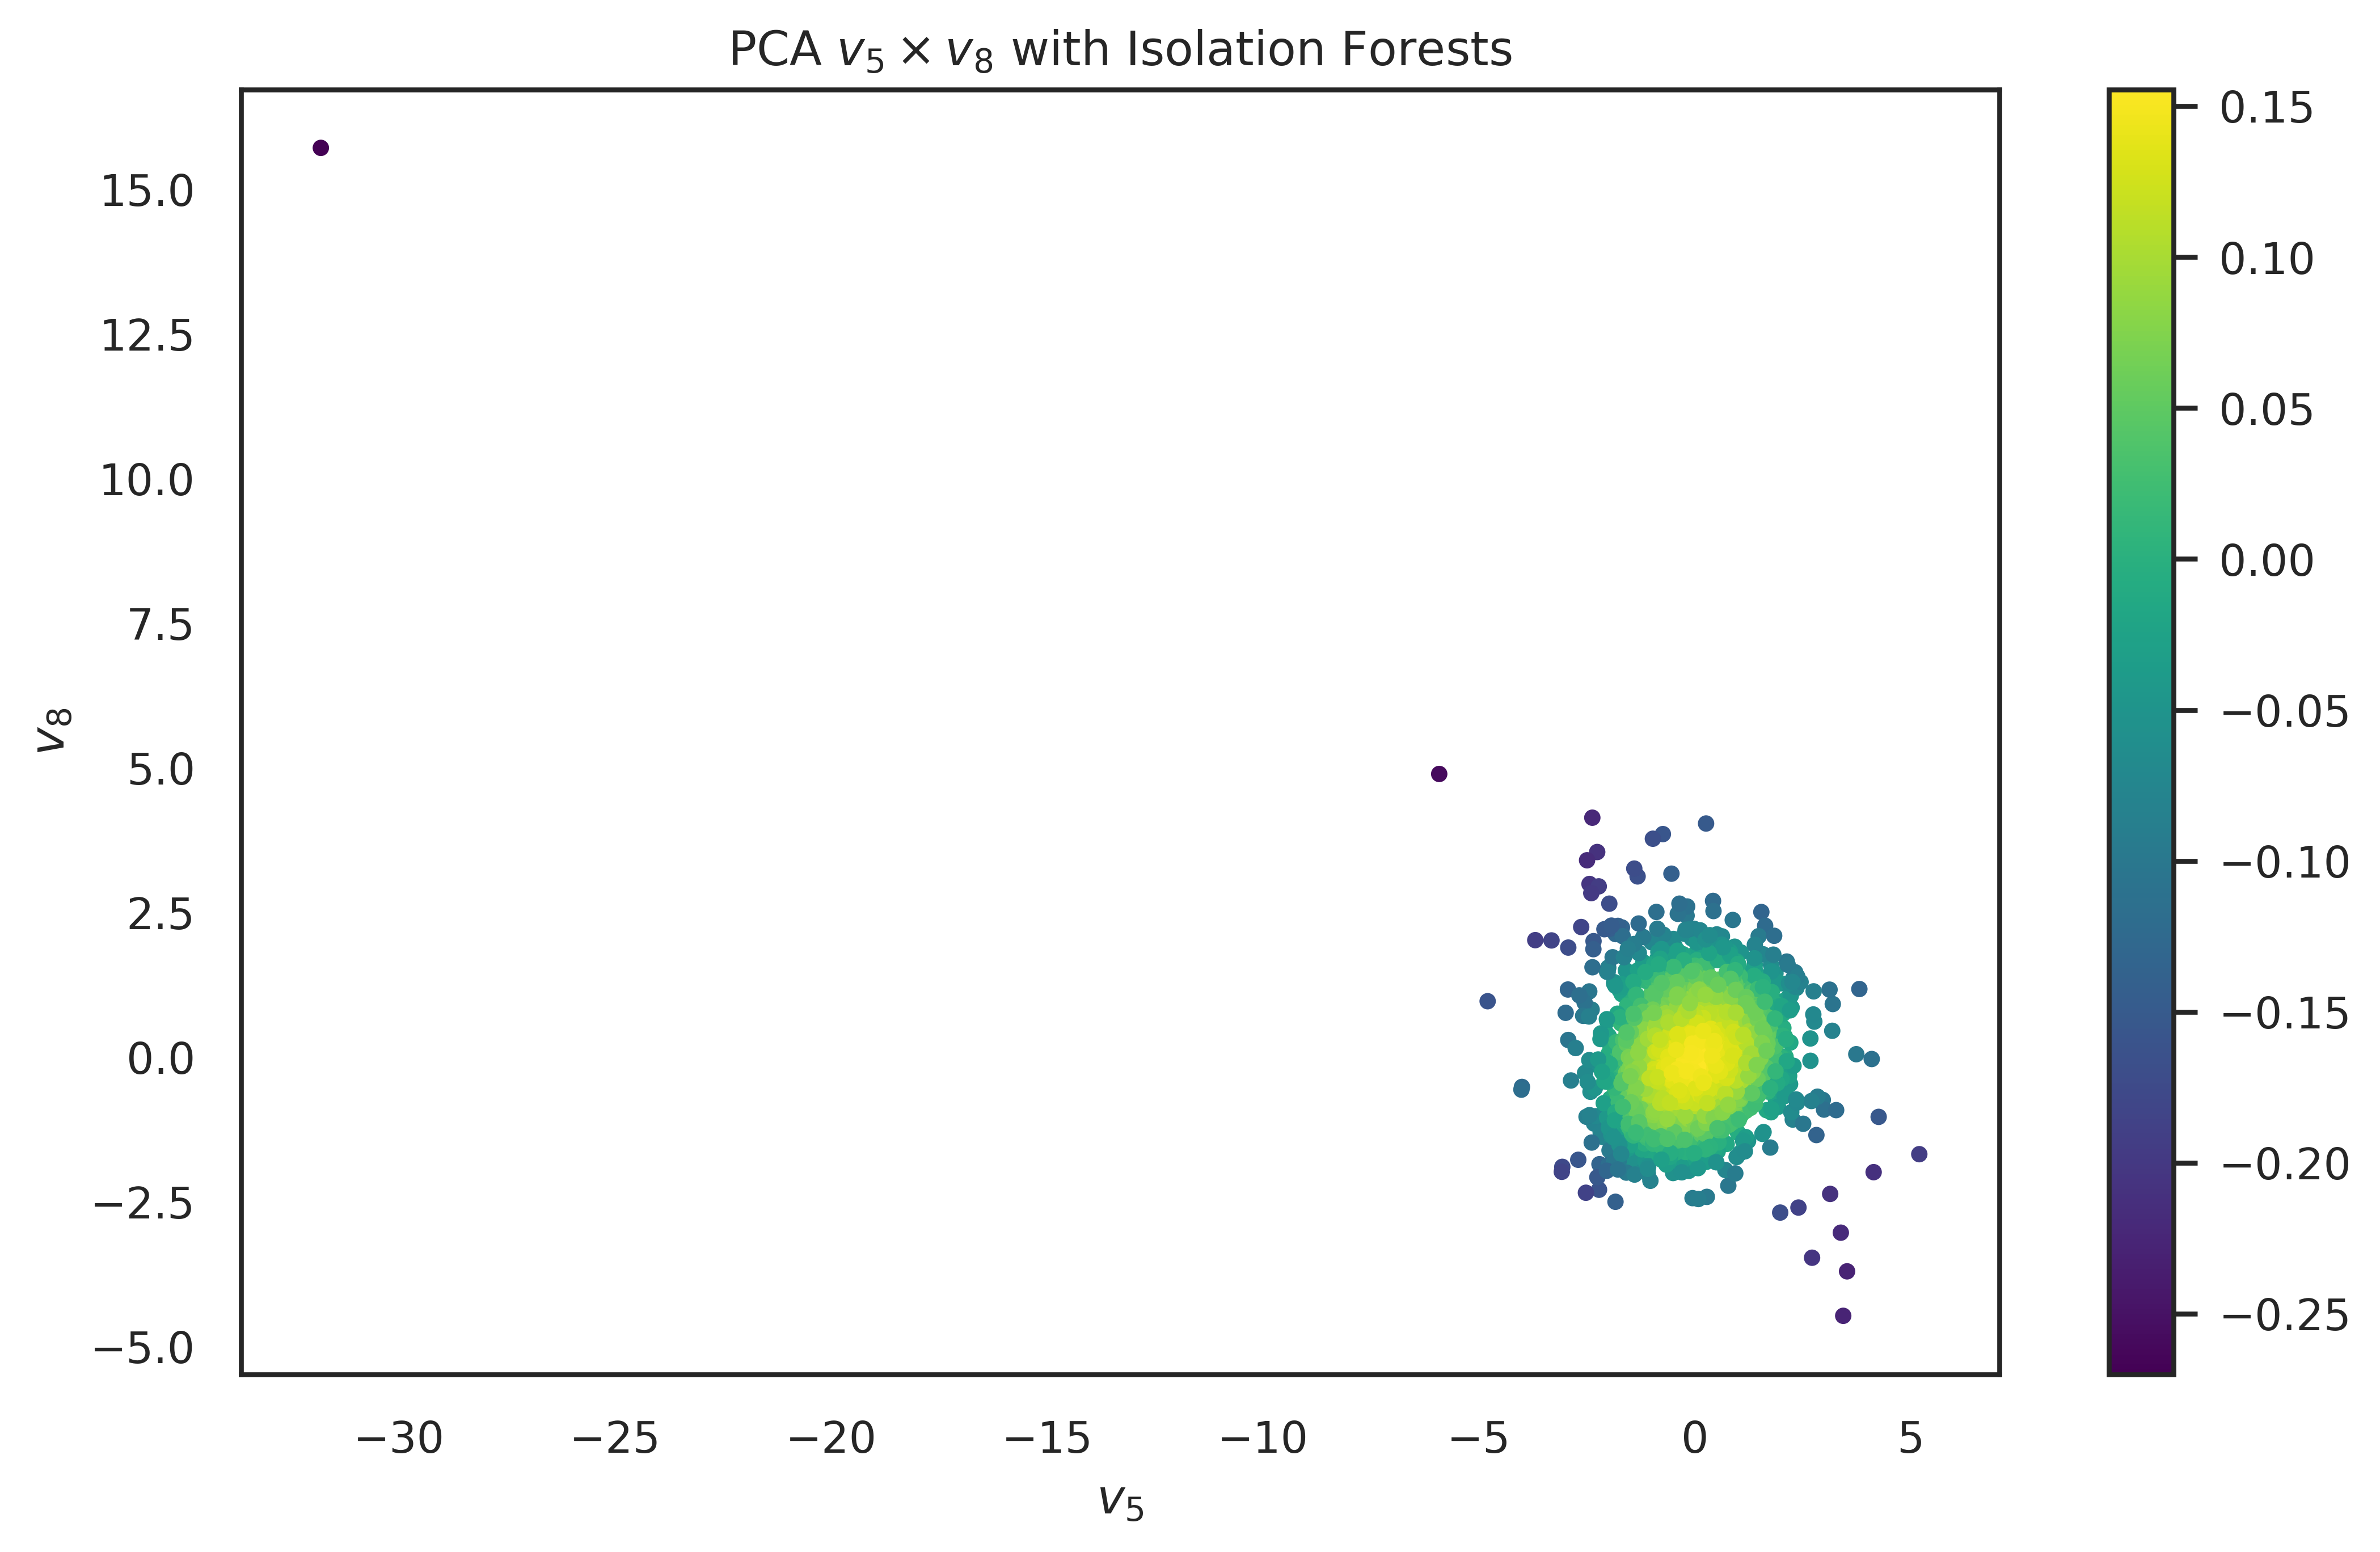

In [12]:
plot_evecproj(evecs_MTM, 5,8, M)